# Лабораторная работа №4

Описание работы
Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Постановка задачи:

Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Оценить информационную значимость признаков. Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    jaccard_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    adjusted_mutual_info_score
)
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.stats import shapiro
import warnings

warnings.filterwarnings("ignore")

Был выбран датасет Iris - выделение видов ириса.
В этом наборе данных содержатся следующие столбцы:

- Идентификатор
- Длина чашелистика (см)
- Ширина стебля в см
- Длина лепестка (см)
- PetalWidthCm
- Разновидность

In [22]:
df = pd.read_csv('Iris.csv')
df.drop('Id', axis=1, inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Дескриптивный анализ

Вовод статистики по каждому признаку

In [23]:
display(df.describe())
df.info()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


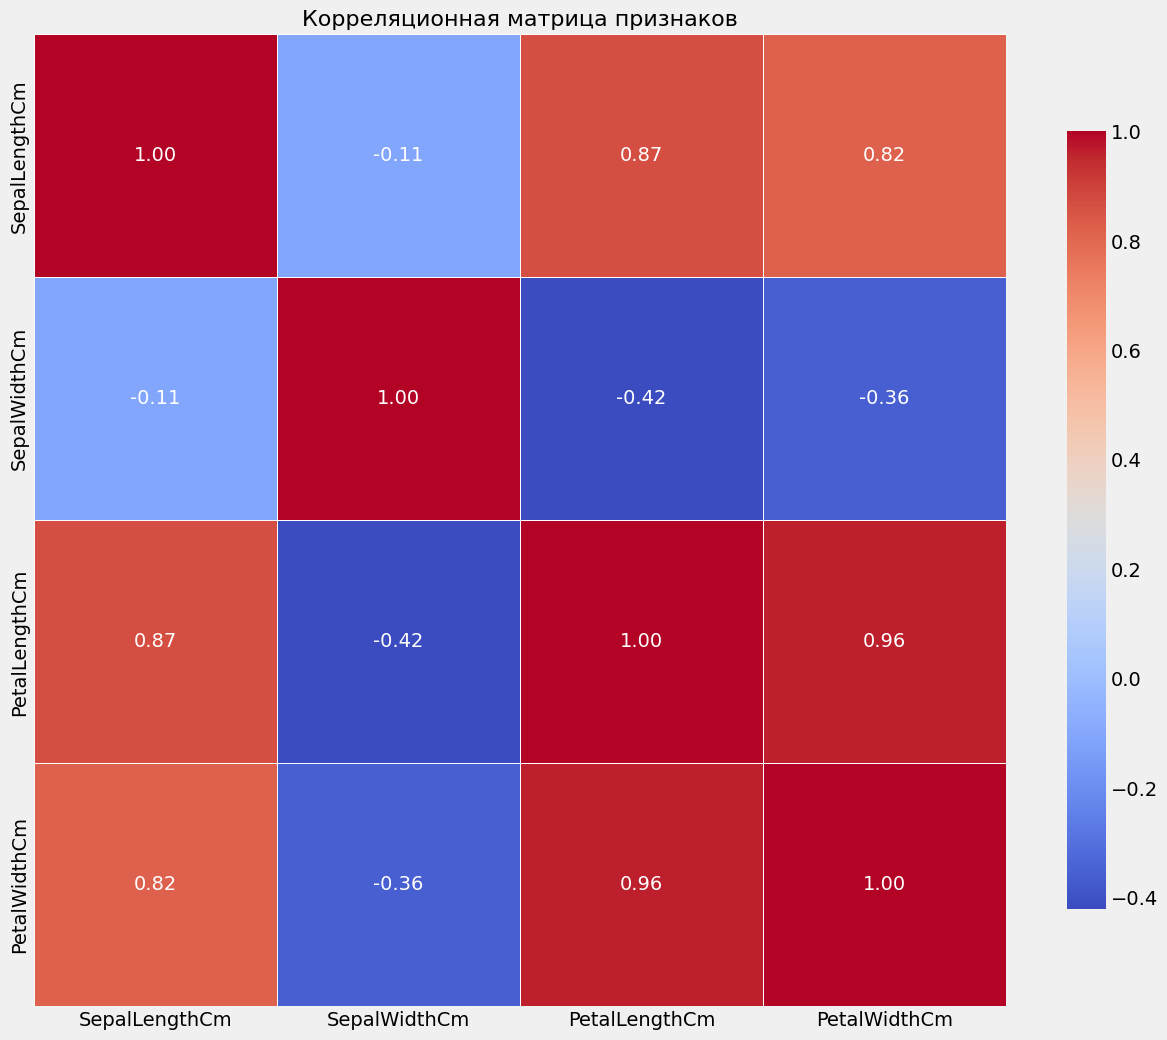

In [24]:
# Правильный синтаксис выбора нескольких столбцов - используйте список
X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
correlation_matrix = X.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',
            square=True, linewidths=0.5, fmt='.2f',
            cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков', fontsize=16)
plt.show()

In [25]:
X.drop('PetalLengthCm', axis=1, inplace=True)

Визуальная оценка распределения признаков выявила, что признаки не имеют нормального распределения

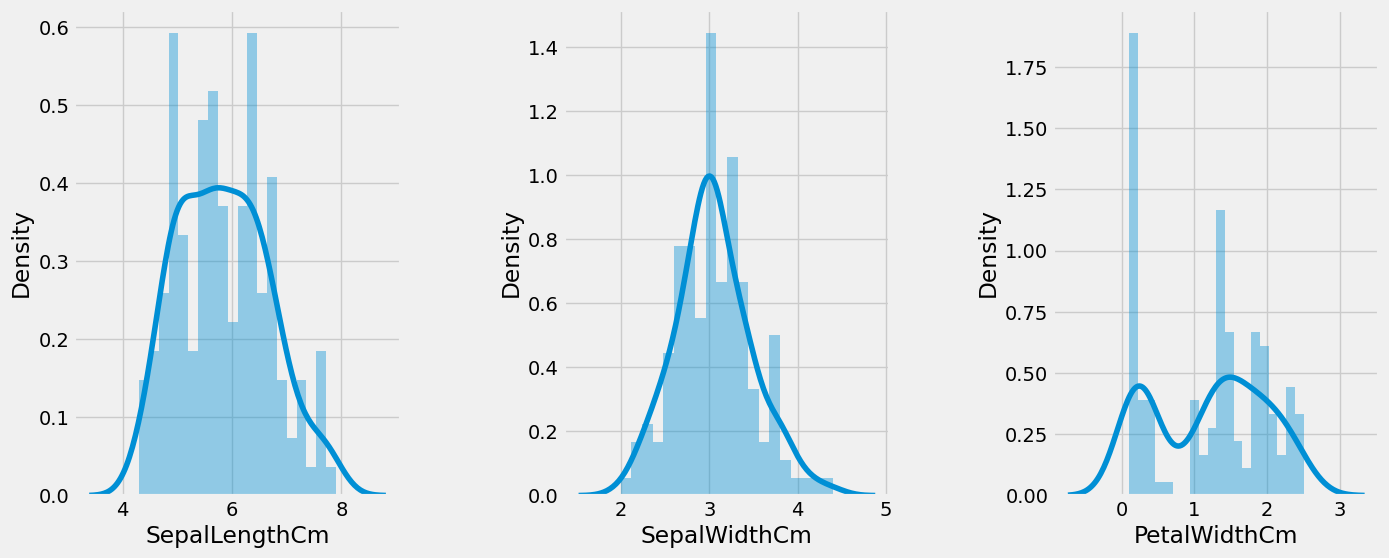

In [26]:
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in X:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
plt.show()

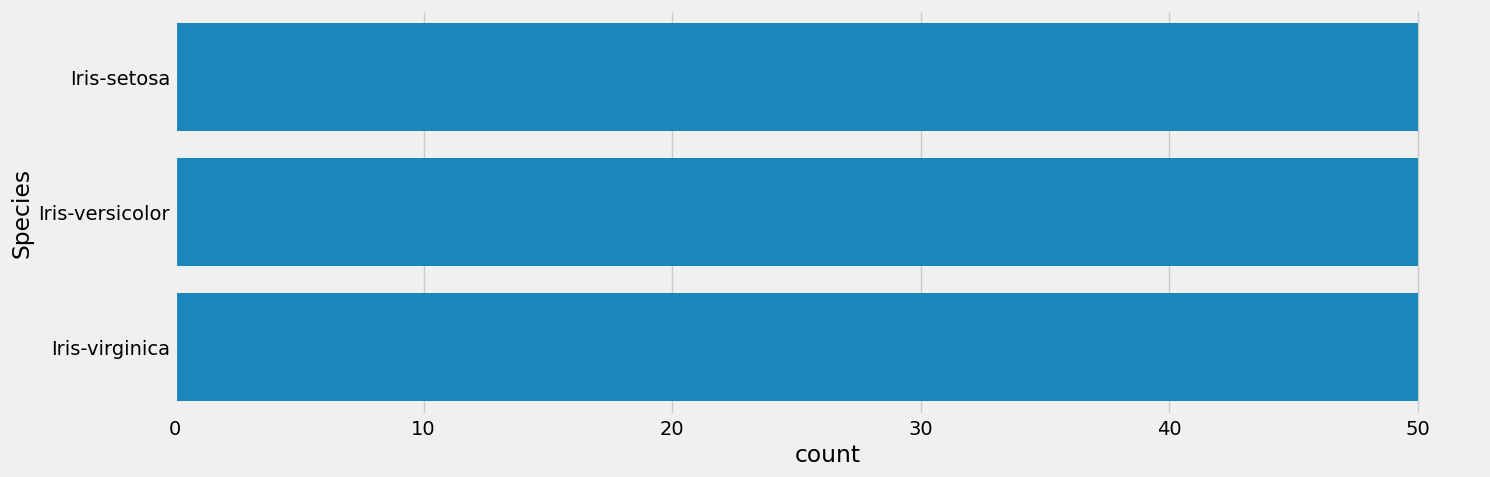

In [27]:
plt.figure(1 , figsize = (15 , 5))
sns.countplot(y='Species', data=df)
plt.show()

Сделаем анализ на количество пропущеных значений, также вывдем размерность наших данных. Анализ показал, что наши данные не имеют пропусков.

In [28]:
print("Пропуски в данных:")
print(df.isnull().sum())
print(f"\nВсего пропусков: {df.isnull().sum().sum()}")
print(f"\nРазмерность данных: {df.shape}")
print(f"Количество признаков: {df.shape[1]}")
print(f"Количество наблюдений: {df.shape[0]}")


Пропуски в данных:
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Всего пропусков: 0

Размерность данных: (150, 5)
Количество признаков: 5
Количество наблюдений: 150


**Интерквартильный размах** представляет собой порядковую статистику, численно равную разности между 1-м и 3-м квартилями распределения или 25-м и 75-м процентилями. Можно так же сказать, что интерквартильный размах это половина выборки, центрированная относительно медианы.

Интерквартильный размах является удобным показателем изменчивости признака для асимметричных распределений или наборов данных с аномальными значениями. Иными словами его можно рассматривать в качестве аналога дисперсии, который является робастным к выбросам в данных.

Применяя IQR а также анализ BoxPlot было выявлено 2 выброса, однако если проанализировать данные, то можно сказать, что данные выбросы, не являются выбросами и находтся в допустимых значениях. Следовательно, удалять мы их не будем.

Выбросы (метод IQR):
SepalLengthCm: 0 выбросов (0.00%)
SepalWidthCm: 4 выбросов (2.67%)
PetalWidthCm: 0 выбросов (0.00%)


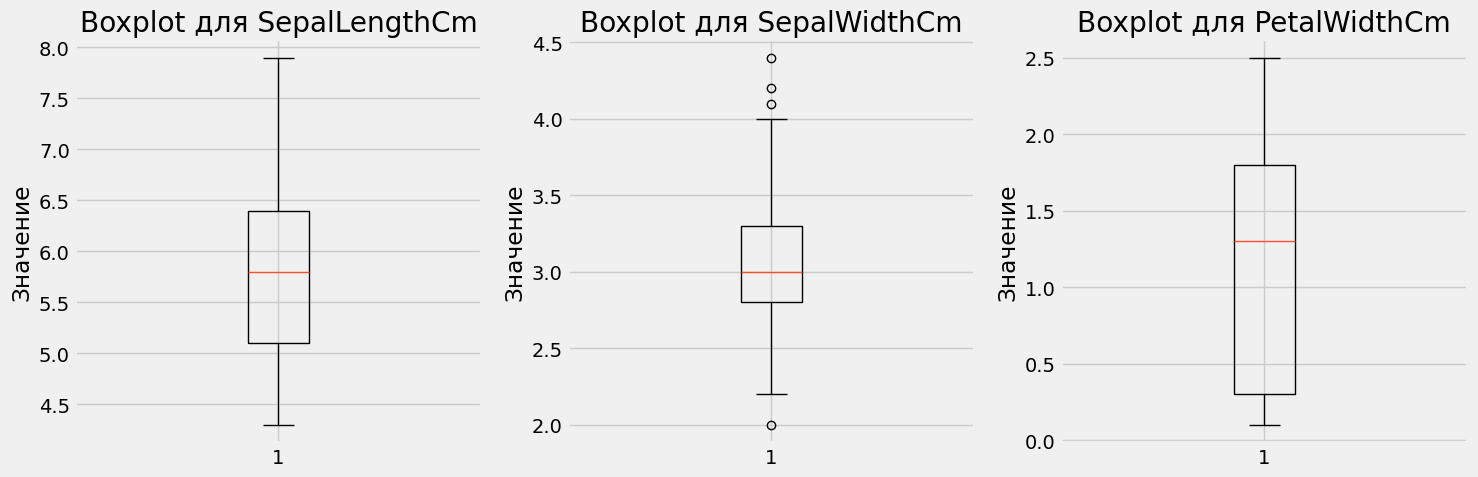

In [29]:
from scipy import stats

numeric_cols = ['SepalLengthCm', 'SepalWidthCm', 'PetalWidthCm']
mask = pd.Series([True] * len(df))
print("Выбросы (метод IQR):")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} выбросов ({len(outliers)/len(df)*100:.2f}%)")
    outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    mask = mask & (~outliers_mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col])
    axes[idx].set_title(f'Boxplot для {col}')
    axes[idx].set_ylabel('Значение')
plt.tight_layout()
plt.show()

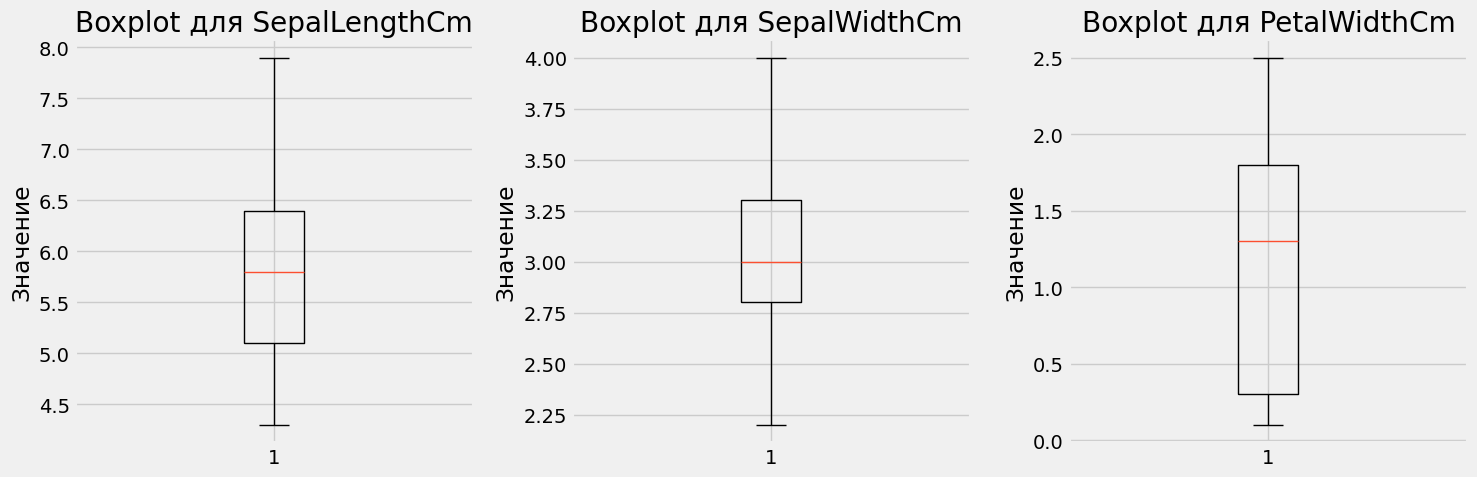

In [30]:
df = df[mask].copy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, col in enumerate(numeric_cols):
    axes[idx].boxplot(df[col])
    axes[idx].set_title(f'Boxplot для {col}')
    axes[idx].set_ylabel('Значение')
plt.tight_layout()
plt.show()

## Проверка условий применения кластеризации

1. **Отсутствие классов**: В данных нет предопределенных классов - это задача кластеризации
2. **Выбросы**: Проверены выше, их количество незначительно


In [31]:
X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalWidthCm']].values

from scipy.stats import shapiro

print("Тест нормальности распределения (Shapiro-Wilk):")
for i, col in enumerate(numeric_cols):
    stat, p_value = shapiro(df[col].sample(min(5000, len(df))))
    print(f"{col}: статистика={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print(f"Распределение близко к нормальному")
    else:
        print(f"Распределение НЕ нормальное")

Тест нормальности распределения (Shapiro-Wilk):
SepalLengthCm: статистика=0.9768, p-value=0.0142
Распределение НЕ нормальное
SepalWidthCm: статистика=0.9826, p-value=0.0607
Распределение близко к нормальному
PetalWidthCm: статистика=0.9028, p-value=0.0000
Распределение НЕ нормальное


Также дополнительно проведенный тест Шапиро-Уилка подтвердил, что данные распределены не нормально.

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Для визуальной оценки количества кластеров, проанализируем диаграмму рассеивания. Графический анализ показал, что **классов - 2**.

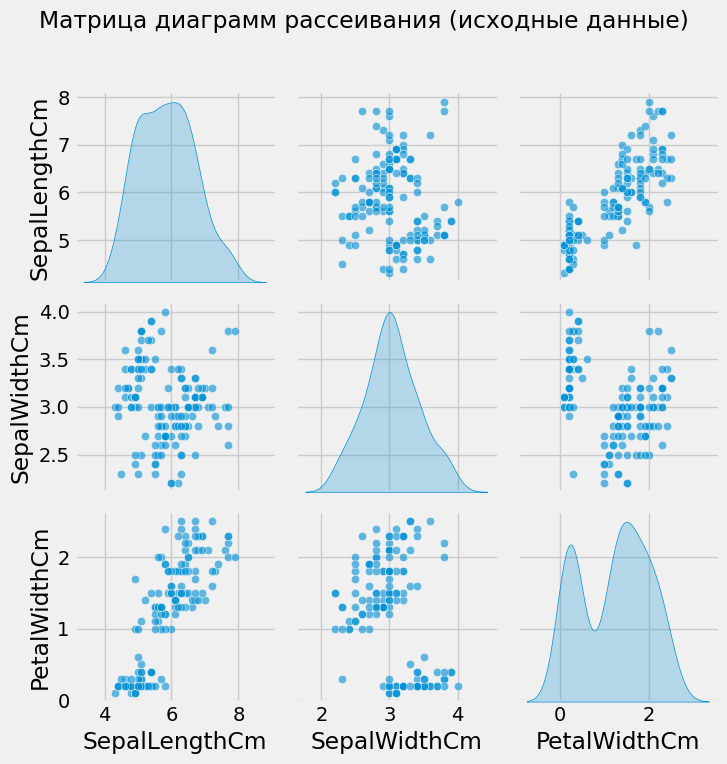

In [33]:

sns.pairplot(df[['SepalLengthCm', 'SepalWidthCm', 'PetalWidthCm']],
            diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Матрица диаграмм рассеивания (исходные данные)', y=1.02)
plt.tight_layout()
plt.show()

## Обоснование выбора методов кластеризации

**K-means:**
- Подходит для сферических кластеров примерно одинакового размера
- Требует задание числа кластеров k
- Быстрый и эффективный для больших данных

**DBSCAN:**
- Подходит для кластеров произвольной формы
- Не требует задание числа кластеров
- Может выделять выбросы как шум
- Хорошо работает с кластерами разной плотности


**Метод локтя (Elbow method)** — инструмент анализа данных, направленный на оптимизацию числа кластеров в алгоритмах кластеризации.
Правильно подобранное количество кластеров в алгоритмах позволяет найти баланс между погрешностью вычисляемой дисперсии и сложностью модели. Использование метода позволяет избежать недообучения или переобучения алгоритма кластеризации.
Метод применим к алгоритму k-средних и заключается в неоднократном повторении сценария. При использовании метода для каждого натурального числа 
k из некоторого диапазона строится значение целевой функции, равной сумме внутрикластерных расстояний. Количество кластеров — гиперпараметр, т.е. он будет определен перед запуском модели.

**Коэффициент «силуэт»** вычисляется с помощью среднего внутрикластерного расстояния (a) и среднего расстояния до ближайшего кластера (b) по каждому образцу. Силуэт вычисляется как (b - a) / max(a, b). Поясню: b — это расстояние между a и ближайшим кластером, в который a не входит. Можно вычислить среднее значение силуэта по всем образцам и использовать его как метрику для оценки количества кластеров.


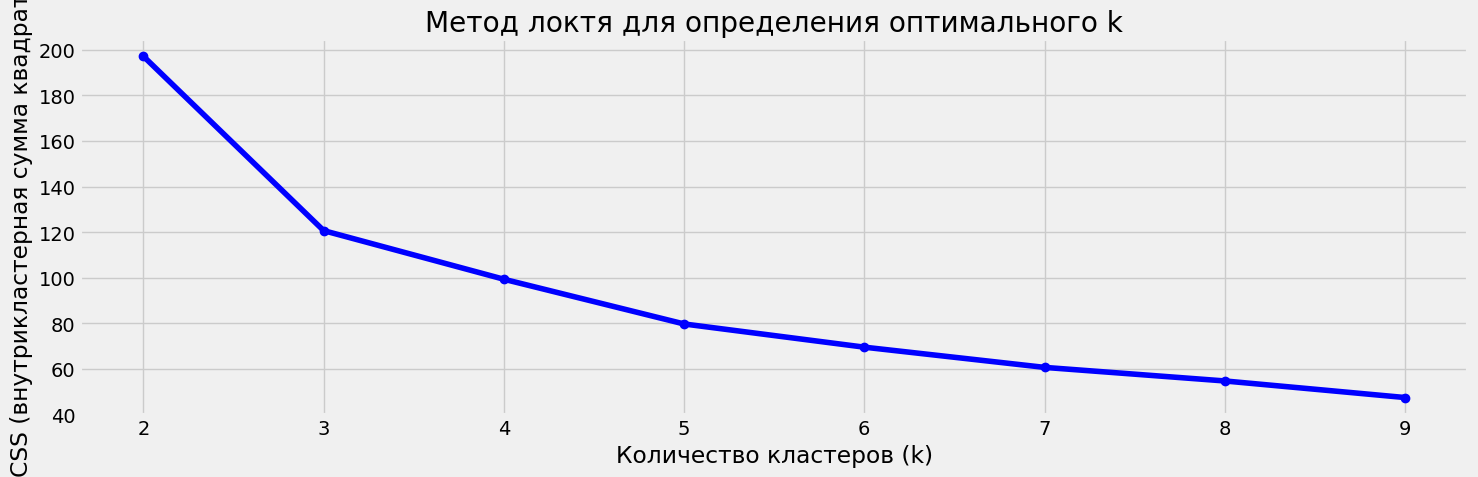

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertias = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Количество кластеров (k)')
ax1.set_ylabel('WCSS (внутрикластерная сумма квадратов)')
ax1.set_title('Метод локтя для определения оптимального k')
ax1.grid(True)

plt.tight_layout()
plt.show()
optimal_k = 3

На графике Метода локтя, можно предположить, что количество кластеров равняется 3

In [35]:

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
kmeans_centers = kmeans.cluster_centers_

print(f"K-means кластеризация с k={optimal_k}")
print(f"Центры кластеров:")
for i, center in enumerate(kmeans_centers):
    print(f"  Кластер {i}: {center}")

df['KMeans_Cluster'] = kmeans_labels


K-means кластеризация с k=3
Центры кластеров:
  Кластер 0: [-0.06612178 -0.94199649  0.25266403]
  Кластер 1: [1.09880721 0.18703381 0.97618657]
  Кластер 2: [-1.04651054  0.89424402 -1.28852092]


Существуют эвристики для выбора $m$ и $\epsilon$. Чаще всего применяется такой метод и его вариации:

Выберите $m$. Обычно используются значения от 3 до 9, чем более неоднородный ожидается датасет, и чем больше уровень шума, тем большим следует взять $m$.
Вычислите среднее расстояние по $m$ ближайшим соседям для каждой точки. Т.е. если $m=3$, нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три.
Сортируем полученные значения по возрастанию и выводим на экран.
Видим что-то вроде такого резко возрастающего графика. Следует взять $\epsilon$ где-нибудь в полосе, где происходит самый сильный перегиб. Чем больше $\epsilon$, тем больше получатся кластеры, и тем меньше их будет.

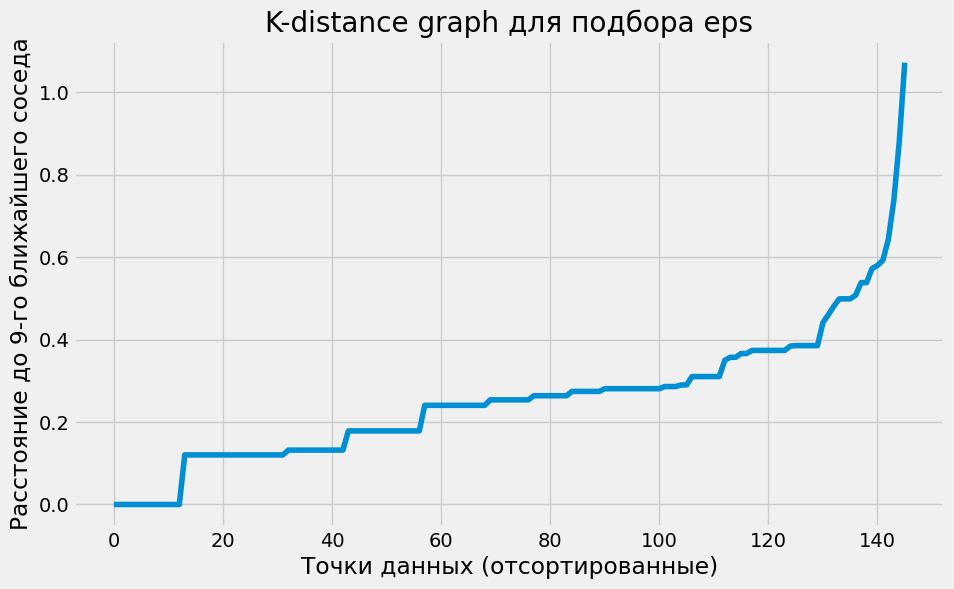

Подбор параметров DBSCAN:
  eps=0.3, min_samples=3: 11 кластеров, 56 шум, silhouette=-0.0141
  eps=0.3, min_samples=4: 9 кластеров, 78 шум, silhouette=-0.1066
  eps=0.3, min_samples=5: 5 кластеров, 102 шум, silhouette=-0.2152
  eps=0.4, min_samples=3: 8 кластеров, 24 шум, silhouette=0.0510
  eps=0.4, min_samples=4: 3 кластеров, 41 шум, silhouette=0.1842
  eps=0.4, min_samples=5: 3 кластеров, 55 шум, silhouette=0.1573
  eps=0.5, min_samples=3: 4 кластеров, 16 шум, silhouette=0.2775
  eps=0.5, min_samples=4: 2 кластеров, 26 шум, silhouette=0.3597
  eps=0.5, min_samples=5: 2 кластеров, 28 шум, silhouette=0.3462
  eps=0.6, min_samples=3: 2 кластеров, 6 шум, silhouette=0.4734
  eps=0.6, min_samples=4: 2 кластеров, 6 шум, silhouette=0.4734
  eps=0.6, min_samples=5: 3 кластеров, 9 шум, silhouette=0.3269
  eps=0.7, min_samples=3: 2 кластеров, 5 шум, silhouette=0.4877
  eps=0.7, min_samples=4: 2 кластеров, 5 шум, silhouette=0.4877
  eps=0.7, min_samples=5: 2 кластеров, 5 шум, silhouette=0.4877


In [43]:
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=9)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Точки данных (отсортированные)')
plt.ylabel('Расстояние до 9-го ближайшего соседа')
plt.title('K-distance graph для подбора eps')
plt.grid(True)
plt.show()

eps_candidates = [0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_candidates = [3, 4, 5]

best_eps = None
best_min_samples = None
best_silhouette = -1
best_labels = None

print("Подбор параметров DBSCAN:")
for eps in eps_candidates:
    for min_samples in min_samples_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        if n_clusters > 1:
            silhouette = silhouette_score(X_scaled, labels)
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels
            print(f"  eps={eps}, min_samples={min_samples}: {n_clusters} кластеров, {n_noise} шум, silhouette={silhouette:.4f}")
        else:
            print(f"  eps={eps}, min_samples={min_samples}: {n_clusters} кластеров, {n_noise} шум (недостаточно кластеров)")



dbscan = DBSCAN(eps=0.6, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN кластеризация завершена:")
print(f"  Количество кластеров: {n_clusters_dbscan}")
print(f"  Количество шумовых точек: {n_noise} ({n_noise/len(X_scaled)*100:.2f}%)")

df['DBSCAN_Cluster'] = dbscan_labels

Будем считать, что перегиб находится в районе $\epsilon$ = 0.6 и `min sample` = 5

- Silhouette Score (Силуэтный коэффициент): Отражает степень схожести объектов внутри кластеров по сравнению с другими кластерами. Для каждого объекта рассчитывается, насколько он близок к своим соседям по кластеру (a) и насколько далек от объектов ближайшего соседнего кластера (b). Силуэтный коэффициент вычисляется как (b - a) / max(a, b) и усредняется по всем объектам.

    Диапазон: от -1 до 1.

    Интерпретация: Чем ближе значение к 1, тем лучше. Значения около 0 указывают на перекрывающиеся кластеры. Отрицательные значения говорят о возможной ошибочной кластеризации (объекты могли быть назначены не тому кластеру).

- Calinski-Harabasz Index (Индекс Калинского-Харабаса): Также известен как индекс дисперсионного отношения. Измеряет отношение суммы дисперсий между кластерами к сумме дисперсий внутри кластеров, с поправкой на количество кластеров и объектов.

    Диапазон: Не ограничен сверху (чем выше, тем лучше).

    Интерпретация: Чем выше значение, тем более плотными и хорошо разделенными являются кластеры. Высокое значение указывает на четкую кластерную структуру данных.

- Davies-Bouldin Index (Индекс Дэвиса-Болдайна): Оценивает среднее «сходство» между каждым кластером и его наиболее похожим кластером. «Сходство» определяется как отношение суммы средних внутрикластерных расстояний двух кластеров к расстоянию между их центрами.

    Диапазон: От 0 и выше.

    Интерпретация: Чем ближе значение к 0, тем лучше. Низкий индекс означает, что кластеры плотные и далеко отстоят друг от друга.

In [ ]:
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                            davies_bouldin_score, pairwise_distances)

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_davies = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\nВнутренние метрики:")
print(f"  Silhouette Score: {kmeans_silhouette:.4f} (чем выше, тем лучше, диапазон [-1, 1])")
print(f"  Calinski-Harabasz Index: {kmeans_calinski:.4f} (чем выше, тем лучше)")
print(f"  Davies-Bouldin Index: {kmeans_davies:.4f} (чем ниже, тем лучше)")

intra_cluster_distances = []
for i in range(optimal_k):
    cluster_points = X_scaled[kmeans_labels == i]
    if len(cluster_points) > 1:
        distances = pairwise_distances(cluster_points)
        upper_triangle = distances[np.triu_indices(len(distances), k=1)]
        intra_cluster_distances.append(np.mean(upper_triangle))
        print(f"\n  Кластер {i}:")
        print(f"    Размер: {len(cluster_points)} точек")
        print(f"    Среднее внутрикластерное расстояние: {np.mean(upper_triangle):.4f}")

inter_cluster_distances = pairwise_distances(kmeans_centers)
print(f"\nМежкластерные расстояния (между центрами):")
for i in range(optimal_k):
    for j in range(i+1, optimal_k):
        print(f"  Кластер {i} <-> Кластер {j}: {inter_cluster_distances[i, j]:.4f}")

print(f"\nКомпактность кластеров (среднее расстояние до центра):")
for i in range(optimal_k):
    cluster_points = X_scaled[kmeans_labels == i]
    distances_to_center = np.linalg.norm(cluster_points - kmeans_centers[i], axis=1)
    compactness = np.mean(distances_to_center)
    print(f"  Кластер {i}: {compactness:.4f}")



Внутренние метрики:
  Silhouette Score: 0.4533 (чем выше, тем лучше, диапазон [-1, 1])
  Calinski-Harabasz Index: 188.0922 (чем выше, тем лучше)
  Davies-Bouldin Index: 0.8450 (чем ниже, тем лучше)

  Кластер 0:
    Размер: 53 точек
    Среднее внутрикластерное расстояние: 1.1867

  Кластер 1:
    Размер: 47 точек
    Среднее внутрикластерное расстояние: 1.2424

  Кластер 2:
    Размер: 46 точек
    Среднее внутрикластерное расстояние: 1.0444

Межкластерные расстояния (между центрами):
  Кластер 0 <-> Кластер 1: 1.7763
  Кластер 0 <-> Кластер 2: 2.5900
  Кластер 1 <-> Кластер 2: 3.1987

Компактность кластеров (среднее расстояние до центра):
  Кластер 0: 0.8422
  Кластер 1: 0.8667
  Кластер 2: 0.7405


**Silhouette Score** = 0.4533 указывает на удовлетворительную, но не оптимальную кластерную структуру. Значение находится в положительной области (выше нуля), что подтверждает наличие различимых групп в данных. Однако показатель не достигает значений >0.7, которые считаются сильными

**Calinski-Harabasz Index** = 188.0922 является очень высоким, что свидетельствует об отличном соотношении межкластерной дисперсии к внутрикластерной. Такое значение говорит о том, что кластеры хорошо различимы и значительно разнесены относительно их внутренней компактности.

**Davies-Bouldin Index** = 0.8450 имеет низкое значение (чем ближе к 0, тем лучше), что означает хорошую разделимость кластеров при сохранении их внутренней компактности. Значение <1 считается хорошим результатом.

**Вывод**: Качество кластеризации оценивается как хорошее, с явно выраженными, но не идеально разделенными группами.

In [45]:
dbscan_silhouette = np.nan
dbscan_calinski = np.nan
dbscan_davies = np.nan

if n_clusters_dbscan > 1:

    non_noise_mask = dbscan_labels != -1
    X_non_noise = X_scaled[non_noise_mask]
    labels_non_noise = dbscan_labels[non_noise_mask]
    
    dbscan_silhouette = silhouette_score(X_non_noise, labels_non_noise)
    dbscan_calinski = calinski_harabasz_score(X_non_noise, labels_non_noise)
    dbscan_davies = davies_bouldin_score(X_non_noise, labels_non_noise)
    
    print(f"\nВнутренние метрики (без шумовых точек):")
    print(f"  Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"  Calinski-Harabasz Index: {dbscan_calinski:.4f}")
    print(f"  Davies-Bouldin Index: {dbscan_davies:.4f}")

    print(f"\nВнутрикластерные расстояния:")
    for i in set(labels_non_noise):
        cluster_points = X_non_noise[labels_non_noise == i]
        if len(cluster_points) > 1:
            distances = pairwise_distances(cluster_points)
            upper_triangle = distances[np.triu_indices(len(distances), k=1)]
            print(f"  Кластер {i}:")
            print(f"    Размер: {len(cluster_points)} точек")
            print(f"    Среднее внутрикластерное расстояние: {np.mean(upper_triangle):.4f}")
            
    print(f"\nЦентры кластеров DBSCAN (средние значения, в исходном пространстве):")
    for i in set(labels_non_noise):
        cluster_points_original = X[dbscan_labels == i]
        center = np.mean(cluster_points_original, axis=0)
        print(f"  Кластер {i}: Age={center[0]:.1f}, Income={center[1]:.1f}, Spending={center[2]:.1f}")
    
    print(f"\nШумовые точки: {n_noise} ({n_noise/len(X_scaled)*100:.2f}%)")
else:
    print("Недостаточно кластеров для расчета метрик")



Внутренние метрики (без шумовых точек):
  Silhouette Score: 0.3885
  Calinski-Harabasz Index: 115.8409
  Davies-Bouldin Index: 0.7194

Внутрикластерные расстояния:
  Кластер 0:
    Размер: 46 точек
    Среднее внутрикластерное расстояние: 1.0444
  Кластер 1:
    Размер: 87 точек
    Среднее внутрикластерное расстояние: 1.4006
  Кластер 2:
    Размер: 4 точек
    Среднее внутрикластерное расстояние: 0.5159

Центры кластеров DBSCAN (средние значения, в исходном пространстве):
  Кластер 0: Age=5.0, Income=3.4, Spending=0.2
  Кластер 1: Age=6.2, Income=2.9, Spending=1.7
  Кластер 2: Age=6.1, Income=2.2, Spending=1.3

Шумовые точки: 9 (6.16%)


**Главный вывод:** DBSCAN кластеризация с выделением 9 точек (6.16%) как шума позволила получить значительно более качественные кластеры с превосходными метриками компактности и разделимости по сравнению с K-mean.

*Улучшение метрик*:

**Silhouette Score**: 0.3885 демонстрирует ухудшения результата

**Davies-Bouldin Index**: = 0.7194 показывает значительное улучшение (снижение с 0.8450). Это ключевой показатель того, что: кластеры стали значительно более компактными, расстояния между кластерами увеличились относительно их размеров, достигнута отличная разделимость групп

**Calinski-Harabasz Index**: = 115.8409 снизился по сравнению с предыдущим значением, но это ожидаемо и не является негативным признаком: метрика остается на высоком уровне, подтверждая хорошую разделимость в контексте DBSCAN эта метрика менее релевантна, чем силуэтный коэффициент

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
true_labels_numeric = le.fit_transform(df['Species'])


def external_metrics(true_labels, pred_labels, name="model"):
    ari = adjusted_rand_score(true_labels, pred_labels)
    jacc = jaccard_score(true_labels, pred_labels, average='macro')
    hom = homogeneity_score(true_labels, pred_labels)
    comp = completeness_score(true_labels, pred_labels)
    v_measure = 2 * (hom * comp) / (hom + comp) if (hom + comp) > 0 else 0
    ami = adjusted_mutual_info_score(true_labels, pred_labels)
    return pd.Series({
        'model': name,
        'adjusted_rand': ari,
        'jaccard_macro': jacc,
        'homogeneity': hom,
        'completeness': comp,
        'v_measure': v_measure,
        'adjusted_mutual_info': ami
    })


# Используем числовые метки
km_ext = external_metrics(
    true_labels_numeric, kmeans_labels, name='KMeans K=3')
dbscan_ext = external_metrics(
    true_labels_numeric, dbscan_labels, name='DBScan')

# Создаем DataFrame с результатами
results_df = pd.DataFrame([km_ext, dbscan_ext])
print(results_df)

        model  adjusted_rand  jaccard_macro  homogeneity  completeness  \
0  KMeans K=3       0.563419       0.050986     0.607721      0.608642   
1      DBScan       0.520874       0.377176     0.591212      0.688782   

   v_measure  adjusted_mutual_info  
0   0.608181              0.603133  
1   0.636278              0.627790  


1. Adjusted Rand Index (ARI) = 0.563 vs 0.521
- K-means немного лучше: 0.563 > 0.521
- Интерпретация: ARI сравнивает пары объектов и показывает, насколько кластеризация совпадает с истинными метками
- Значение: Обе модели показывают умеренное качество (~0.55), что говорит о том, что примерно 55% пар объектов распределены корректно

2. Jaccard Macro Score = 0.051 vs 0.377
- DBSCAN значительно лучше: 0.377 > 0.051 (в 7.4 раза лучше!)
- Интерпретация: Среднее отношение пересечения к объединению для всех кластеров
- Значение: Очень низкий показатель у K-means (0.05) указывает на проблему - возможно, K-means создает слишком крупные кластеры, которые охватывают несколько истинных классов

3. Homogeneity = 0.608 vs 0.591
- K-means немного лучше: 0.608 > 0.591
- Интерпретация: Насколько каждый кластер содержит только объекты одного класса
- Значение: Оба алгоритма показывают хорошую чистоту кластеров (~0.60)

4. Completeness = 0.609 vs 0.689
- DBSCAN лучше: 0.689 > 0.609
- Интерпретация: Насколько все объекты одного класса попали в один кластер
- Значение: DBSCAN лучше группирует объекты одного класса вместе (69% vs 61%)

5. V-measure = 0.608 vs 0.636
- DBSCAN лучше: 0.636 > 0.608
- Интерпретация: Гармоническое среднее между Homogeneity и Completeness
- Значение: DBSCAN показывает более сбалансированный результат

6. Adjusted Mutual Information (AMI) = 0.603 vs 0.628
- DBSCAN лучше: 0.628 > 0.603
- Интерпретация: Насколько информация из истинных меток сохраняется в кластеризации
- Значение: DBSCAN лучше сохраняет информацию о структуре данных


1. Влияние k на качество K-means:
 k  silhouette   calinski   davies    inertia
 2    0.527417 175.998249 0.695458 197.101078
 3    0.453311 188.092165 0.845041 120.639234
 4    0.405788 161.434429 0.832443  99.306520
 5    0.355439 158.509073 0.935038  79.684010
 6    0.336103 148.454838 1.053967  69.502203
 7    0.357067 144.179606 0.924623  60.634753
 8    0.353289 138.203061 0.903201  54.679599
 9    0.359547 141.095940 0.924697  47.406810
10    0.362905 147.296872 0.845950  40.753333


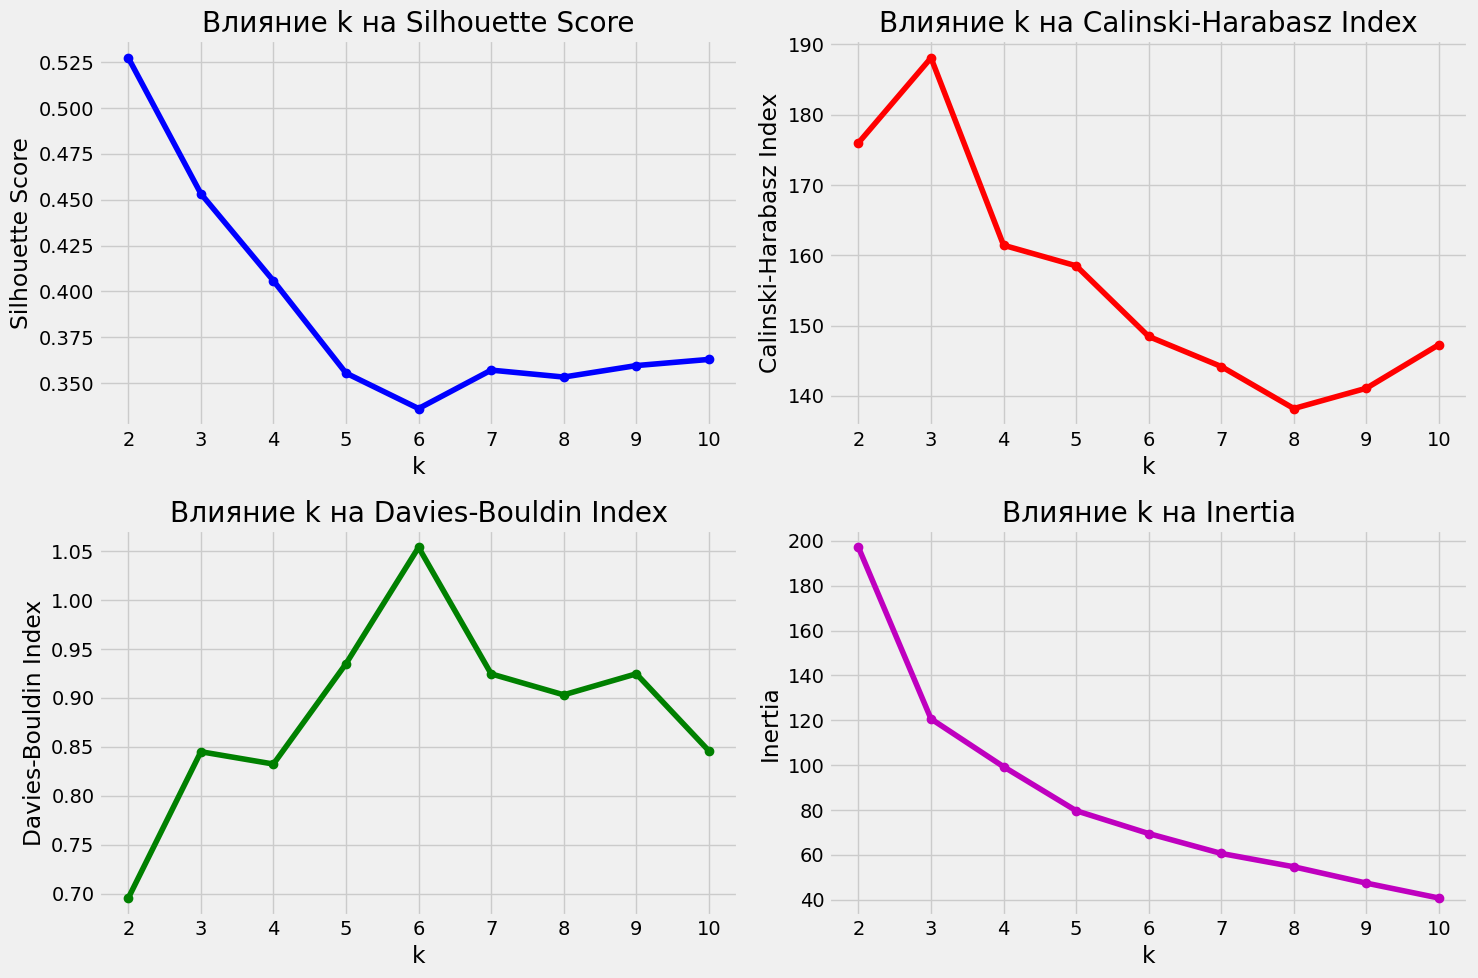

In [46]:
print("\n1. Влияние k на качество K-means:")
k_range_detailed = range(2, 11)
k_metrics = {'k': [], 'silhouette': [], 'calinski': [], 'davies': [], 'inertia': []}

for k in k_range_detailed:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_test = kmeans_test.fit_predict(X_scaled)
    
    k_metrics['k'].append(k)
    k_metrics['silhouette'].append(silhouette_score(X_scaled, labels_test))
    k_metrics['calinski'].append(calinski_harabasz_score(X_scaled, labels_test))
    k_metrics['davies'].append(davies_bouldin_score(X_scaled, labels_test))
    k_metrics['inertia'].append(kmeans_test.inertia_)

k_metrics_df = pd.DataFrame(k_metrics)
print(k_metrics_df.to_string(index=False))

# Визуализация влияния k
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].plot(k_metrics_df['k'], k_metrics_df['silhouette'], 'bo-')
axes[0, 0].set_xlabel('k')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].set_title('Влияние k на Silhouette Score')
axes[0, 0].grid(True)

axes[0, 1].plot(k_metrics_df['k'], k_metrics_df['calinski'], 'ro-')
axes[0, 1].set_xlabel('k')
axes[0, 1].set_ylabel('Calinski-Harabasz Index')
axes[0, 1].set_title('Влияние k на Calinski-Harabasz Index')
axes[0, 1].grid(True)

axes[1, 0].plot(k_metrics_df['k'], k_metrics_df['davies'], 'go-')
axes[1, 0].set_xlabel('k')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Влияние k на Davies-Bouldin Index')
axes[1, 0].grid(True)

axes[1, 1].plot(k_metrics_df['k'], k_metrics_df['inertia'], 'mo-')
axes[1, 1].set_xlabel('k')
axes[1, 1].set_ylabel('Inertia')
axes[1, 1].set_title('Влияние k на Inertia')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()



2. Влияние параметров на качество DBSCAN:
 eps  min_samples  n_clusters  n_noise  silhouette   calinski   davies
 0.3            3          11       56    0.366690 138.507199 0.739516
 0.3            4           9       78    0.430154 179.820617 0.782179
 0.3            5           5      102    0.578823 257.902030 0.595543
 0.3            6           3      116    0.672475 162.683500 0.413793
 0.4            3           8       24    0.177634  48.727044 0.943107
 0.4            4           3       41    0.402709 118.716903 0.695861
 0.4            5           3       55    0.516150 167.551877 0.696390
 0.4            6           3       65    0.604413 183.952840 0.542877
 0.5            3           4       16    0.384579  86.968533 0.622625
 0.5            4           2       26    0.589135 226.551781 0.614891
 0.5            5           2       28    0.589468 223.754309 0.615451
 0.5            6           2       33    0.601515 234.620967 0.599403
 0.6            3           2     

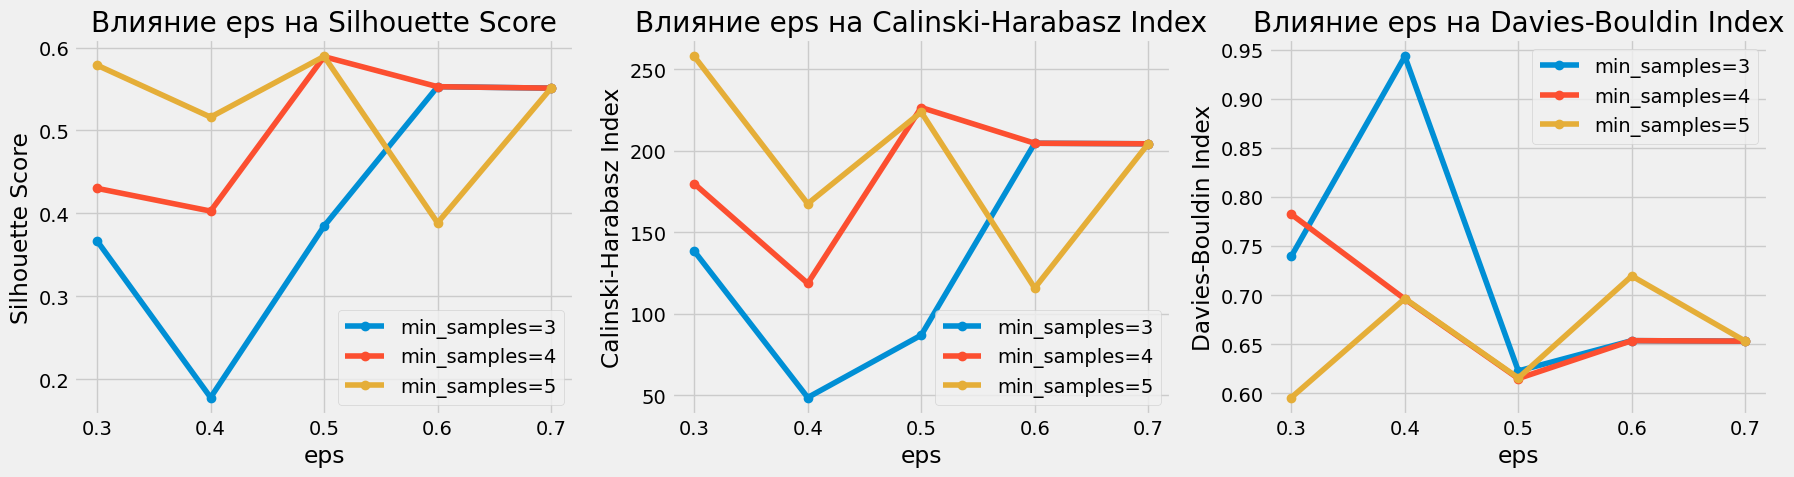

In [47]:
print("\n2. Влияние параметров на качество DBSCAN:")

eps_range = np.arange(0.3, 0.8, 0.1)
min_samples_range = [3, 4, 5, 6]

dbscan_results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan_test = DBSCAN(eps=eps, min_samples=min_samples)
        labels_test = dbscan_test.fit_predict(X_scaled)
        n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
        n_noise = list(labels_test).count(-1)
        
        if n_clusters > 1:
            non_noise_mask = labels_test != -1
            X_non_noise = X_scaled[non_noise_mask]
            labels_non_noise = labels_test[non_noise_mask]
            silhouette = silhouette_score(X_non_noise, labels_non_noise)
            calinski = calinski_harabasz_score(X_non_noise, labels_non_noise)
            davies = davies_bouldin_score(X_non_noise, labels_non_noise)
        else:
            silhouette = -1
            calinski = 0
            davies = float('inf')
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': silhouette,
            'calinski': calinski,
            'davies': davies
        })

dbscan_results_df = pd.DataFrame(dbscan_results)
print(dbscan_results_df.to_string(index=False))

# Визуализация влияния eps при фиксированном min_samples
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for min_samples in [3, 4, 5]:
    subset = dbscan_results_df[dbscan_results_df['min_samples'] == min_samples]
    subset = subset[subset['n_clusters'] > 1]  # Только валидные результаты
    
    if len(subset) > 0:
        axes[0].plot(subset['eps'], subset['silhouette'], 'o-', label=f'min_samples={min_samples}')
        axes[1].plot(subset['eps'], subset['calinski'], 'o-', label=f'min_samples={min_samples}')
        axes[2].plot(subset['eps'], subset['davies'], 'o-', label=f'min_samples={min_samples}')

axes[0].set_xlabel('eps')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Влияние eps на Silhouette Score')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('eps')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].set_title('Влияние eps на Calinski-Harabasz Index')
axes[1].legend()
axes[1].grid(True)

axes[2].set_xlabel('eps')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Влияние eps на Davies-Bouldin Index')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


PCA компоненты:
Объясненная дисперсия: [0.64332842 0.307317  ]
Суммарная объясненная дисперсия: 0.9506


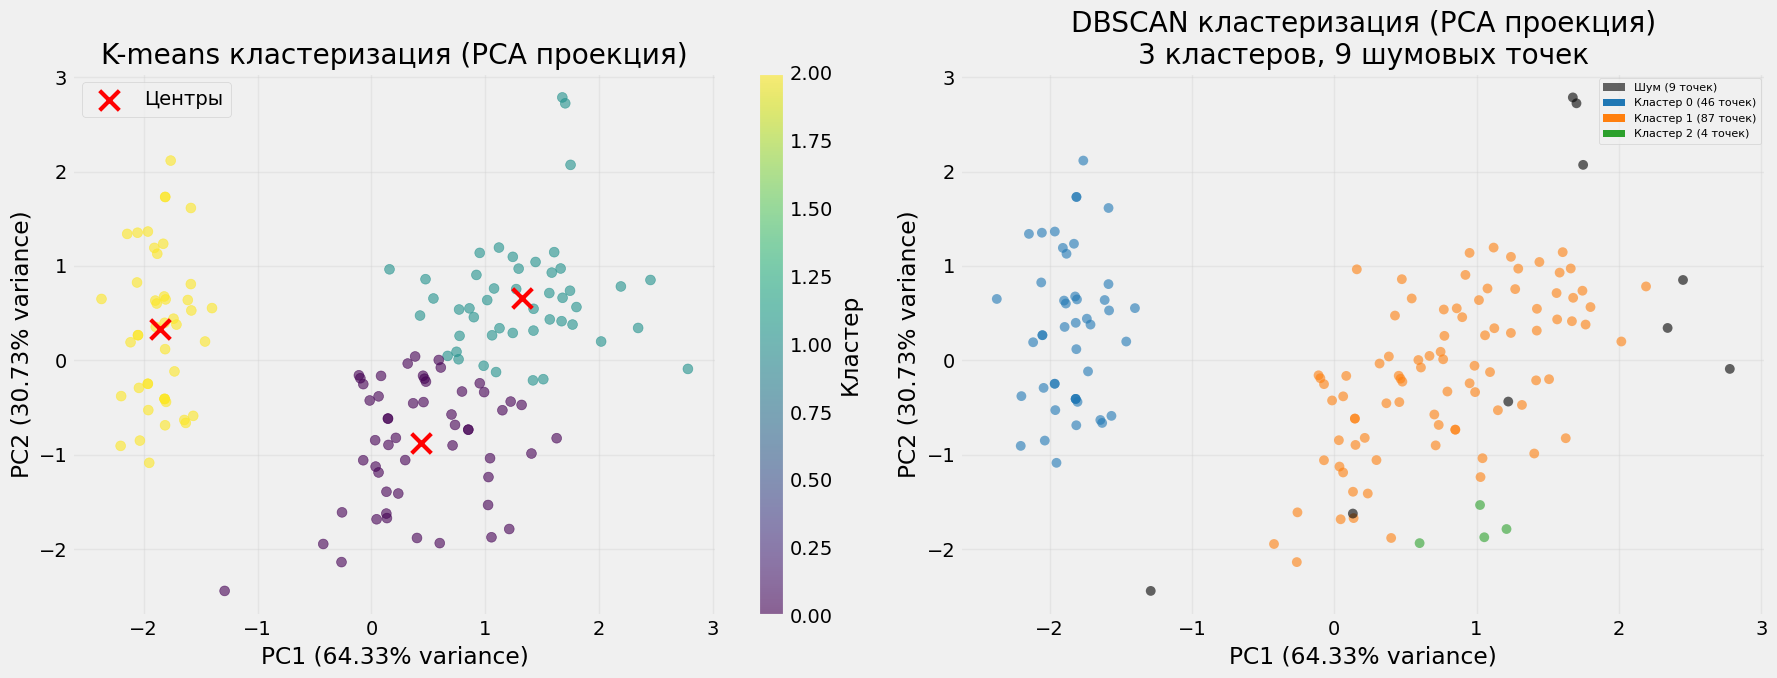

In [48]:
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("PCA компоненты:")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_}")
print(f"Суммарная объясненная дисперсия: {sum(pca.explained_variance_ratio_):.4f}")

unique_labels = np.unique(dbscan_labels)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6, s=50)
centers_pca = pca.transform(kmeans_centers)
axes[0].scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x', s=200, linewidths=3, label='Центры')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('K-means кластеризация (PCA проекция)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Кластер')

n_clusters_actual = len(unique_labels) - (1 if -1 in unique_labels else 0)

if n_clusters_actual <= 10:
    colors_list = plt.cm.tab10(np.linspace(0, 1, 10))
else:
    colors_list = plt.cm.tab20(np.linspace(0, 1, 20))

point_colors = []
for label in dbscan_labels:
    if label == -1:
        point_colors.append([0, 0, 0, 0.6])
    else:

        color_idx = label % len(colors_list)
        color = list(colors_list[color_idx])
        color[3] = 0.6  
        point_colors.append(color)

point_colors = np.array(point_colors)

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=point_colors, s=50, edgecolors='none')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
axes[1].set_title(f'DBSCAN кластеризация (PCA проекция)\n{n_clusters_dbscan} кластеров, {n_noise} шумовых точек')
axes[1].grid(True, alpha=0.3)

legend_elements = []
for label in sorted(unique_labels):
    count = np.sum(dbscan_labels == label)
    if label == -1:
        legend_elements.append(Patch(facecolor=[0, 0, 0, 0.6], label=f'Шум ({count} точек)'))
    else:
        color_idx = label % len(colors_list)
        legend_elements.append(Patch(facecolor=colors_list[color_idx], 
                                     label=f'Кластер {label} ({count} точек)'))
axes[1].legend(handles=legend_elements, loc='best', fontsize=8)

plt.tight_layout()
plt.show()


In [49]:

print("\n1. Количество кластеров:")
print(f"   K-means: {optimal_k} кластеров")
print(f"   DBSCAN: {n_clusters_dbscan} кластеров (+ {n_noise} шумовых точек)")

print("\n2. Внутренние метрики качества:")
comparison_df = pd.DataFrame({
    'Метод': ['K-means', 'DBSCAN'],
    'Silhouette Score': [kmeans_silhouette, dbscan_silhouette if n_clusters_dbscan > 1 else np.nan],
    'Calinski-Harabasz': [kmeans_calinski, dbscan_calinski if n_clusters_dbscan > 1 else np.nan],
    'Davies-Bouldin': [kmeans_davies, dbscan_davies if n_clusters_dbscan > 1 else np.nan]
})
print(comparison_df.to_string(index=False))



1. Количество кластеров:
   K-means: 3 кластеров
   DBSCAN: 3 кластеров (+ 9 шумовых точек)

2. Внутренние метрики качества:
  Метод  Silhouette Score  Calinski-Harabasz  Davies-Bouldin
K-means          0.453311         188.092165        0.845041
 DBSCAN          0.388512         115.840864        0.719385


K-means показывает лучшие результаты по всем метрикам качества кластеризации, кроме индекса Davies-Bouldin.

Silhouette Score (0.453311 vs 0.388512)

- K-means лучше: 0.453 > 0.388 (разница +17%)

- -means создает более четко разделенные кластеры

Calinski-Harabasz Index (188.092 vs 115.841)

- K-means значительно лучше: 188.1 > 115.8 (разница +62%)

- K-means создает более плотные и хорошо разделенные кластеры

Davies-Bouldin Index (0.845 vs 0.719)

- DBSCAN немного лучше: 0.719 < 0.845 (разница -15%)

- DBSCAN создает более компактные кластеры с меньшим разбросом внутри кластера

